# **News Media**

In [1]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# DB 연결
# !pip install pymysql
import pymysql

# 실시간 주식가격 데이터
# !pip install finance-datareader
import FinanceDataReader as fdr

# 텍스트 분석
from konlpy.tag import Okt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# 기타
import datetime
from collections import Counter

## **Read Data**

### **① KOSELF 감성 어휘 사전**

In [2]:
# 블로그에서 가져온 기본적인 한국어 긍부정 텍스트 목록
with open('positive_words_self.txt', encoding='utf-8') as pos_blog:
    positive_blog = pos_blog.readlines()
positive_blog = [pos_blog.replace('\n', '') for pos_blog in positive_blog]
with open('negative_words_self.txt', encoding='utf-8') as neg_blog:
    negative_blog = neg_blog.readlines()
negative_blog = [neg_blog.replace('\n', '') for neg_blog in negative_blog]

# KOSELF 감성 어휘 사전
with open('KOSELF_pos.txt', encoding='utf-8') as pos:
    positive = pos.readlines()
positive = [pos.replace('\n', '') for pos in positive]
with open('KOSELF_neg.txt', encoding='utf-8') as neg:
    negative = neg.readlines()
negative = [neg.replace('\n', '') for neg in negative]

### **② News Data from DB**

In [3]:
# AWS 서버 사용할 수 없을 때
corp_list = ['samsung', 'hyundai', 'lg', 'sk']
stock_list = ['005930', '005380', '051910', '000660']

for i in range(len(corp_list)):
    globals()[corp_list[i]] = pd.read_csv('../../../../code/news_craw_{}.csv'.format(stock_list[i]))
    globals()[corp_list[i]]['date'] = globals()[corp_list[i]]['date'].apply(lambda _: str(_))

In [4]:
for i in range(len(corp_list)):
    globals()[corp_list[i]].rename(columns={'date': 'datetime'}, inplace=True)
    
    # DataFrame 형태를 통일하기 위해 date 컬럼 추가
    globals()[corp_list[i]]['date'] = globals()[corp_list[i]]['datetime'].str[0:4] + '-' + globals()[corp_list[i]]['datetime'].str[4:6] + '-' + globals()[corp_list[i]]['datetime'].str[6:8]
    globals()[corp_list[i]]['date'] = pd.to_datetime(globals()[corp_list[i]]['date'])
    
    # 결측치 제거 → 데이터 로드 시 완료했기 때문에 그다지 필요하지 않은 과정
    globals()[corp_list[i]] = globals()[corp_list[i]].dropna()
    
    # 시간순으로 정렬
    globals()[corp_list[i]].sort_values('datetime', inplace=True)
    globals()[corp_list[i]].reset_index(inplace=True, drop=True)

In [5]:
# samsung, hyndai, lg, sk 데이터 불러오기 완료

### **③ FinanceDataReader**

In [6]:
start_date = '20180101'
end_date = datetime.datetime.now().strftime("%Y%m%d")

for i in range(len(corp_list)):
    globals()['stock_' + corp_list[i]] = fdr.DataReader(stock_list[i], start=start_date, end=end_date).reset_index()

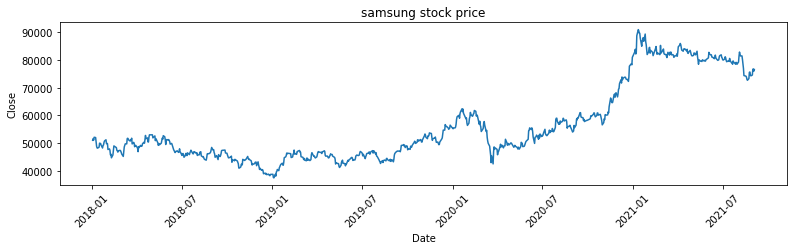

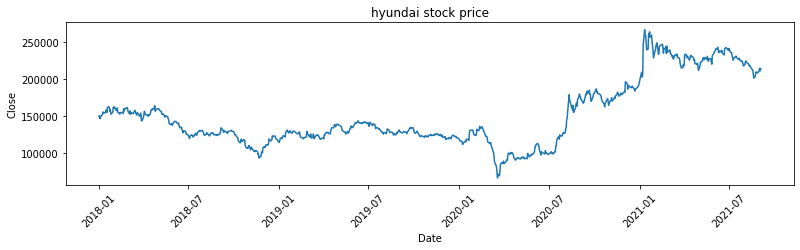

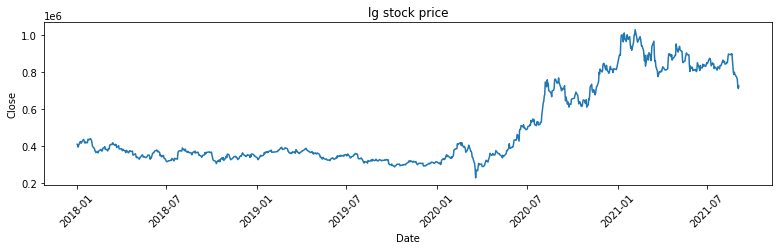

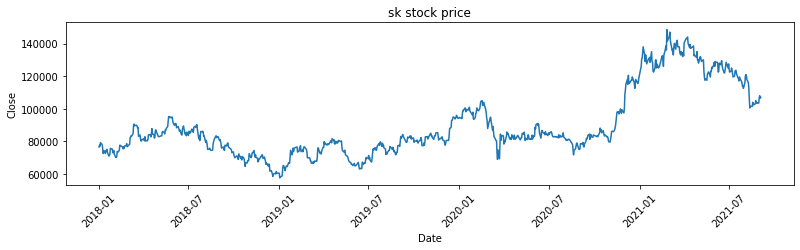

In [7]:
# 종목별 주식가격 변동
for i in range(len(corp_list)):
    plt.figure(figsize=(60, 3))
    plt.subplot(1, 4, i+1)
    sns.lineplot(data=globals()['stock_' + corp_list[i]], x='Date', y='Close')
    plt.title(corp_list[i] + ' stock price')
    plt.xticks(rotation=45)

plt.show()

### **④ Holidays**

In [8]:
holidays = pd.read_csv('holidays.csv')

holidays

,date,year,month,day,dd,explanation,weekend,holiday
0,2018-01-01,2018,1,1,Mon,새해,NaN,O
1,2018-01-02,2018,1,2,Tue,NaN,NaN,NaN
2,2018-01-03,2018,1,3,Wed,NaN,NaN,NaN
3,2018-01-04,2018,1,4,Thu,NaN,NaN,NaN
4,2018-01-05,2018,1,5,Fri,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1821,2022-12-27,2022,12,27,Tue,NaN,NaN,NaN
1822,2022-12-28,2022,12,28,Wed,NaN,NaN,NaN
1823,2022-12-29,2022,12,29,Thu,NaN,NaN,NaN
1824,2022-12-30,2022,12,30,Fri,NaN,NaN,NaN


## **Preprocessing**

In [9]:
# 감성 어휘 사전 : negative / positive
# 뉴스 데이터 : samsung / hyundai / lg / sk
# 주식 데이터 : stock_samsung / stock_hyundai / stock_lg / stock_sk
# 공휴일 데이터 : holidays

### **① 뉴스 데이터 날짜 조정**
- <span style="color:blue">***전일 15시 ~ 금일 15시***</span>

In [10]:
# 업로드 시각 컬럼 추가
for i in range(len(corp_list)):
    globals()[corp_list[i]]['time'] = globals()[corp_list[i]]['datetime'].str[-2:]

In [18]:
after_market = ['15', '16', '17', '18', '19', '20', '21', '22', '23']

for i in range(len(corp_list)):
    for j in range(len(globals()[corp_list[i]]['time'])):
        if globals()[corp_list[i]]['time'][j] in after_market:
            globals()[corp_list[i]]['date'][j] += datetime.timedelta(1)
        else:
            pass

<ipython-input-18-3c2555c49550>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globals()[corp_list[i]]['date'][j] += datetime.timedelta(1)


In [20]:
# 텍스트 전처리
for i in range(len(corp_list)):
    globals()[corp_list[i]]['text'] = globals()[corp_list[i]]['text'].str.replace('[\n|\t|\r]', '')

<ipython-input-20-d7651d5d35fd>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  globals()[corp_list[i]]['text'] = globals()[corp_list[i]]['text'].str.replace('[\n|\t|\r]', '')


### **② 주말 및 공휴일 제외**

In [21]:
market_closed = holidays[holidays['holiday']=="O"].reset_index(drop=True)

market_closed

,date,year,month,day,dd,explanation,weekend,holiday
0,2018-01-01,2018,1,1,Mon,새해,NaN,O
1,2018-01-06,2018,1,6,Sat,NaN,O,O
2,2018-01-07,2018,1,7,Sun,NaN,O,O
3,2018-01-13,2018,1,13,Sat,NaN,O,O
4,2018-01-14,2018,1,14,Sun,NaN,O,O
...,...,...,...,...,...,...,...,...
579,2022-12-17,2022,12,17,Sat,NaN,O,O
580,2022-12-18,2022,12,18,Sun,NaN,O,O
581,2022-12-24,2022,12,24,Sat,NaN,O,O
582,2022-12-25,2022,12,25,Sun,크리스마스,O,O


In [22]:
# 휴장일 list 생성
market_closed_list = list(market_closed['date'])

In [29]:
def stock_market_closed(df):
    for i in range(len(df['date'])):
        if df['date'][i] in market_closed_list:
            df['date'][i] += datetime.timedelta(1)
            stock_market_closed(df)
        else:
            pass
    return df

In [32]:
for i in range(len(corp_list)):
    stock_market_closed(globals()[corp_list[i]])

In [34]:
samsung[samsung['date']=='2021-08-29']

,st_n,st_cd,news,datetime,title,url,text,date,time
6139,삼성전자,5930,매일경제,2021082910,"""이젠 삼성전자도 툭하면 하네""…수십만명은 기본, 백만명 넘게 몰린다",http://news.mk.co.kr/newsRead.php?no=833331&ye...,지난 2일 삼성닷컴 라이브커머스로 진행된 `비스포크 큐커 위크` 방송에서 개그맨 부...,2021-08-29,10
6140,삼성전자,5930,매일경제,2021082911,"'라방'서 완판되는 삼성 비스포크 큐커, MZ세대 사로잡은 비결은",http://news.mk.co.kr/newsRead.php?no=833446&ye...,밀키트와 가정간편식(HMR) 등을 간편하게 요리할 수 있는 삼성전자의 조리기기 '...,2021-08-29,11
6141,삼성전자,5930,매일경제,2021082914,"갤Z플립3 폴드3 리뷰 폐기했던 188만 유튜버 입 열었다 ""직접 써보니…""",http://news.mk.co.kr/newsRead.php?no=833683&ye...,[사진 출처 = 유튜브 잇섭 채널] 188만명의 구독자를 보유한 IT기기 전문 유튜...,2021-08-29,14
6142,삼성전자,5930,매일경제,2021082914,취준생 '꿈의 직장' 삼성 카카오 택한 이유…연봉보다 더 중요한 것은 ?,http://news.mk.co.kr/newsRead.php?no=833746&ye...,"[자료 출처=잡코리아] 대학생 취업준비생 중 남성은 삼성, 여성은 카카오에 가장 입...",2021-08-29,14


## **Sentiment Analysis**